# Data Science & Advanced Analytics <br> Text Analysis & Topic Modelling

### André Panisson <br> Laetitia Gauvin 
#### ISI Foundation
---

In [1]:
%pylab inline

from datetime import datetime
from dateutil import parser
import json
import time
import gzip

Populating the interactive namespace from numpy and matplotlib


# 1. Data Collection

Let's start by collecting some tweets.

We will connect to the Twitter Search API using **twithon**. You can find more about twithon in the [Github repository](https://github.com/ryanmcgrath/twython).
Another implementation of the Twitter APIs for Python programmers is [tweepy](https://github.com/tweepy/tweepy).

In order to connect to the Twitter APIs, you need an API key and an API secret. You can get them in the [Twitter Dev site](https://dev.twitter.com/).

The search API takes one very important parameter: the query (**q**). In the next example, we search for some tweets using the keyword **sotu**. The result is an object in **json** format, parsed as a dictionary. You can access the list of statuses in the `'statuses'` key. For each status, you can access the fields as a key/value dictionary, or you can print the entire status using `json.dumps`.

The next example is a crawler that searches for all tweets with the keyword **sotu**, in reverse time order. We start from the last status (using the last status id as the value for the parameter **max_id**) and keep searching and updating the max_id until we arrive to **date_start**.

If we exceed the rate limit, we sleep the amount of time necessary to reset the rate limit, and start searching again. You can find more about the rate limit status in the [REST API documentation](https://dev.twitter.com/docs/api/1.1/get/application/rate_limit_status).

During the crawling process, we add all statuses to a list.

To finish the data collection step, we save the data to a compressed file.

### Load the collected data

In [79]:
statuses = []
with gzip.open('sotu_2019.json.gz', 'rt') as gf:
    for line in gf:
        statuses.append(json.loads(line))

In [80]:
statuses[0]

{'created_at': 'Mon Feb 04 17:30:55 +0000 2019',
 'id': 1092475601942925312,
 'id_str': '1092475601942925312',
 'text': '#SOTU #SOTUBingo I made this at work today because someone needed to. https://t.co/smtxCIQoLF',
 'truncated': False,
 'entities': {'hashtags': [{'text': 'SOTU', 'indices': [0, 5]},
   {'text': 'SOTUBingo', 'indices': [6, 16]}],
  'symbols': [],
  'user_mentions': [],
  'urls': [],
  'media': [{'id': 1092475555549569024,
    'id_str': '1092475555549569024',
    'indices': [70, 93],
    'media_url': 'http://pbs.twimg.com/media/DylAusZUYAAXxer.jpg',
    'media_url_https': 'https://pbs.twimg.com/media/DylAusZUYAAXxer.jpg',
    'url': 'https://t.co/smtxCIQoLF',
    'display_url': 'pic.twitter.com/smtxCIQoLF',
    'expanded_url': 'https://twitter.com/MindfulTexan/status/1092475601942925312/photo/1',
    'type': 'photo',
    'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'},
     'small': {'w': 635, 'h': 680, 'resize': 'fit'},
     'large': {'w': 1315, 'h': 1409, 'r

Next, we extract some information that could be of our interest. For each status, we create a tuple of `(status_id, text, rt, created_at, lang, user_id)`, and we create a Data Frame with the list of tuples that we created.

In [81]:
tweets = []

for status in statuses:      
    rt = 'retweeted_status' in status
    text = status['retweeted_status']['text'] if rt else status['text']

    tweets.append((np.uint64(status['id_str']),
                   text,
                   rt,
                   status['created_at'],
                   status['lang'],
                   np.uint64(status['user']['id_str'])))

We will use a Pandas dataframe to represent the features extracted from the raw Twitter objects.

In [82]:
import pandas as pd
df = pd.DataFrame(tweets,
                  columns=['status_id', 'text', 'rt', 'created_at', 'lang', 'user_id'])
df = df.set_index('status_id')
df.created_at = pd.to_datetime(df.created_at)
df.head()

,text,rt,created_at,lang,user_id
status_id,,,,,
1092475601942925312,#SOTU #SOTUBingo I made this at work today bec...,False,2019-02-04 17:30:55,en,921516124277272576
1092475575845834752,5 Themes For @realDonaldTrump's #SOTU:\n- Safe...,True,2019-02-04 17:30:49,en,226997507
1092475571119013890,I was privileged this morning to be on a confe...,True,2019-02-04 17:30:48,en,2961331005
1092475570141712384,🤔 It’s illegal to enter 🇺🇸 illegally It’s ille...,False,2019-02-04 17:30:47,en,1471615951
1092475566849060864,"Pledge to skip Trump, and watch the #SOTU resp...",True,2019-02-04 17:30:47,en,1083516312234520576


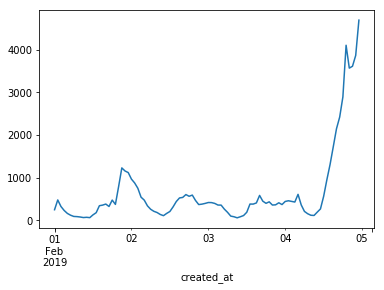

In [26]:
df.groupby(pd.Grouper(key='created_at', freq='h')).size().plot()

# 2. Text Pre-processing

In [10]:
df = df[(df.created_at > '2019-02-01 00:00:00') & (df.created_at < '2019-02-05 00:00:00')]
df.head()

,text,rt,created_at,lang,user_id
status_id,,,,,
1092475601942925312,#SOTU #SOTUBingo I made this at work today bec...,False,2019-02-04 17:30:55,en,921516124277272576
1092475575845834752,5 Themes For @realDonaldTrump's #SOTU:\n- Safe...,True,2019-02-04 17:30:49,en,226997507
1092475571119013890,I was privileged this morning to be on a confe...,True,2019-02-04 17:30:48,en,2961331005
1092475570141712384,🤔 It’s illegal to enter 🇺🇸 illegally It’s ille...,False,2019-02-04 17:30:47,en,1471615951
1092475566849060864,"Pledge to skip Trump, and watch the #SOTU resp...",True,2019-02-04 17:30:47,en,1083516312234520576


In [51]:
df.shape

(62700, 5)

In [53]:
df = df[df.rt == False]

In [54]:
df.shape

(8466, 5)

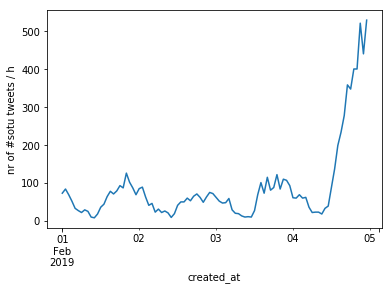

In [55]:
df.groupby(pd.Grouper(key='created_at', freq='h')).size().plot()
plt.ylabel('nr of #sotu tweets / h');

Next, we create a list of **stop words**. Stop words are extremely common words that don't help in text classification since they occur frequently in the language.

In [56]:
from sklearn.feature_extraction import stop_words
stopwords = set(stop_words.ENGLISH_STOP_WORDS)

stopwords.update(['http', 've', 'wa', 'got', 'lt', 'gt', 'rt', 'retweet', 'wasn', 'doing', 'ha', 'oh',
    'amp', 'gotta', 'jeah', 'make', 'going', 'like', 'haha', 'great', 'don', 'really', 'im', 
    'did', 'didn', 'let', 'll', 'u', 'yes', 'lol', 'wouldn', 'sotu'])

In the next step, we create the main tools to process the text: a **tokenizer** and a **lemmatizer**.

The **WordNetLemmatizer** from **nltk** is able to determine the **lemma** for a given word. The lemma is the canonical form of a set of words (e.g., the lemma "go" represents the inflected forms "go", "goes", "going", "went", and "gone"). By grouping together the different inflected forms of a word, they can be analysed as a single term. By default, the method `lemmatize` finds out the lemma for nouns. In order to find out the lemma for adjectives and verbs, we call `lemmatize` with different parameters.

The **tokenizer** is the function that splits the text in different words (or tokens) and returns a list of words. In our example, we don't return directly the words, but the lemmatized form of each word.

Finally, the **analyzer** is the function that returns the list of terms for each document. Each term can be a lemmatized word, or, in the case of this specific analyzer, can be also a bigram or a trigram. The parameter **ngram_range** defines the sizes of n-grams to be included in the terms list.

For example, the following analyzer will return this list of terms for the phrase `'it rains cats and dogs'`:

```python
>>> analyzer('it rains cats and dogs')
[u'rain', u'cat', u'dog', u'rain cat', u'cat dog', u'rain cat dog']
```

In [57]:
from sklearn.feature_extraction import text
import re
#from nltk.stem.wordnet import WordNetLemmatizer

token_pattern = re.compile(r"(?u)\b\w\w+\b")
# lemmatizer = WordNetLemmatizer()

def lemmatize(w):
    return w
    l = lemmatizer.lemmatize(w)
    if l == w:
        l = lemmatizer.lemmatize(w, 'a')
    if l == w:
        l = lemmatizer.lemmatize(w, 'v')
    return l

def tokenizer(doc):
    return [lemmatize(w) for w in token_pattern.findall(doc) if len(w) > 1]

vectorizer = text.CountVectorizer(max_df=0.95,
                                  max_features=100000,
                                  stop_words=stopwords,
                                  ngram_range=(1,3),
                                  tokenizer=tokenizer)

analyzer = vectorizer.build_analyzer()

Next, we use a `Counter` to count the occurrences of each term in our dataset.

In [58]:
from collections import Counter
term_counts = Counter()

for doc in df.text.values:
    term_count_current = Counter(analyzer(doc))
    term_counts.update(term_count_current)

In [59]:
term_counts.most_common(20)

[('https', 7121),
 ('trump', 1573),
 ('realdonaldtrump', 1244),
 ('state', 689),
 ('watch', 637),
 ('union', 619),
 ('state union', 598),
 ('president', 581),
 ('potus', 509),
 ('address', 484),
 ('staceyabrams', 454),
 ('democrats', 409),
 ('tomorrow', 369),
 ('speakerpelosi', 337),
 ('response', 334),
 ('tuesday', 325),
 ('just', 293),
 ('maga', 283),
 ('watching', 271),
 ('speech', 262)]

The number of terms in present in the dataset is in the order of millions. However, not all terms are important, and the more terms we use, the topic extraction will be slower. We limit our set of terms to the list of the top 100k terms, sorted by number of occurrences.

In [60]:
max_features = 100000
term_counts = Counter(dict(term_counts.most_common(max_features)))

With these terms, we create our vocabulary.

In [61]:
terms = set(t for t, tc in term_counts.most_common(max_features))
vocabulary = dict(((t, i) for i, t in enumerate(sorted(terms))))

## From Text Messages to Feature Vectors
We need to transform our text data into feature vectors, numerical representations which are suitable for performing statistical analysis. The most common way to do this is to apply a bag-of-words approach where the frequency of an occurrence of a word becomes a feature for our classifier.

We use the vocabulary created in the previous step to extract the **document-term matrix** `C`.

In [62]:
vectorizer = text.CountVectorizer(vocabulary=vocabulary, 
                                  stop_words=stopwords, 
                                  ngram_range=(1,3), 
                                  tokenizer=tokenizer)

C = vectorizer.fit_transform(df.text.values)

In [63]:
C

<8466x100000 sparse matrix of type '<class 'numpy.int64'>'
	with 192053 stored elements in Compressed Sparse Row format>

### Term Frequency-Inverse Document Frequency

We want to consider the relative importance of particular words, so we'll use term frequency–inverse document frequency as a weighting factor. This will control for the fact that some words are more "spamy" than others.

### Mathematical details

tf–idf is the product of two statistics, term frequency and inverse document
frequency. Various ways for determining the exact values of both statistics
exist. In the case of the '''term frequency''' tf(''t'',''d''), the simplest
choice is to use the ''raw frequency'' of a term in a document, i.e. the
number of times that term ''t'' occurs in document ''d''. If we denote the raw
frequency of ''t'' by f(''t'',''d''), then the simple tf scheme is
tf(''t'',''d'') = f(''t'',''d''). Other possibilities
include:

  * boolean_data_type "frequencies": tf(''t'',''d'') = 1 if ''t'' occurs in ''d'' and 0 otherwise; 
  * logarithmically scaled frequency: tf(''t'',''d'') = log (f(''t'',''d'') + 1); 
  * augmented frequency, to prevent a bias towards longer documents, e.g. raw frequency divided by the maximum raw frequency of any term in the document: $$\mathrm{tf}(t,d) = 0.5 + \frac{0.5 \times \mathrm{f}(t, d)}{\max\{\mathrm{f}(w, d):w \in d\}}$$

The '''inverse document frequency''' is a measure of whether the term is
common or rare across all documents. It is obtained by dividing the total
number of documents by the number of documents containing the
term, and then taking the logarithm of that quotient.

$$\mathrm{idf}(t, D) = \log \frac{|D|}{|\{d \in D: t \in d\}|}$$

with

  * $|D|$: cardinality of D, or the total number of documents in the corpus 
  * $|\{d \in D: t \in d\}|$ : number of documents where the term $t$ appears (i.e., $\mathrm{tf}(t,d) eq 0$). If the term is not in the corpus, this will lead to a division-by-zero. It is therefore common to adjust the formula to $1 + |\{d \in D: t \in d\}|$. 

Mathematically the base of the log function does not matter and constitutes a
constant multiplicative factor towards the overall result.

Then tf–idf is calculated as

$$\mathrm{tfidf}(t,d,D) = \mathrm{tf}(t,d) \times \mathrm{idf}(t, D)$$

In [64]:
from sklearn.feature_extraction import text
tfidf = text.TfidfTransformer()
X = tfidf.fit_transform(C)

In [65]:
X

<8466x100000 sparse matrix of type '<class 'numpy.float64'>'
	with 192053 stored elements in Compressed Sparse Row format>

Finally, we can save the **vocabulary** and **X** variables to be used in the next steps.

# Topic Extraction

## 3. Matrix factorization (20 components)

Let's start by loading the data produced in the previous steps:

We have a matrix $X \in \mathbb{R}^{N \times D}$, where $N$ is the number of status messages and $D$ is the number of terms in the vocabulary. The variable _vocabulary_ contains, for each index, the term associated to that index.

Next, we use Nonnegative Matrix Factorization to factorize the matrix $X \in \mathbb{R}^{N \times D}$ in two matrices, $W \in \mathbb{R}^{N \times R}$ and $H \in \mathbb{R}^{R \times D}$, where $R$ is the number of components that we want to extract - in this example, **20 components**.

In [66]:
from sklearn import decomposition

nr_components = 20

nmf = decomposition.NMF(n_components=nr_components, max_iter=20)
W = nmf.fit_transform(X)
H = nmf.components_

In [43]:
W[:, 0].argsort()

array([31349, 49169, 18957, ..., 28948, 28974, 48149])

## Stream Matrix

The **stream matrix** is a matrix $A \in \mathbb{R}^{R \times T}$, where $R$ is the number of components and $T$ is the number of intervals. Since we want to show the activity of each component in every hour, the stream matrix is a matrix with one column for each hour interval.

We populate the activity of each component using the values in the matrix $W$. We select just the rows of $W$ that refer to a given interval, and populate the activities of each component for the given interval.

The resulting stream matrix is plotted with `pcolormesh`, and we can see that most of the components start with a high activity peak followed by an activity decay.

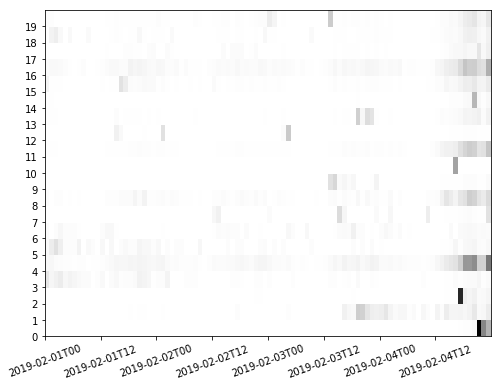

In [69]:
periods = np.arange('2019-02-01', '2019-02-05', dtype='datetime64[h]')
A = zeros((nr_components, periods.shape[0]))

for t, (mn_start, mn_end) in enumerate(zip(periods, periods + np.timedelta64(1, 'h'))):
    mask = (df.created_at > mn_start) & (df.created_at <= mn_end)
    W_minute = W[mask.values]
    
    for i in range(nr_components):
        A[i, t] = W_minute[:, i].sum()

plt.figure(figsize=(8,6))
plt.pcolormesh(A, cmap=cm.gray_r)
plt.ylim(0, A.shape[0])
plt.xlim(0, A.shape[1])
plt.yticks(np.arange(A.shape[0]))
plt.xticks(np.arange(0, A.shape[1], 12), periods[::12], rotation=20);

For each component vector in $W$ (i.e., for each column of $W$), we can sort the weights of the component vector and select the row of $W$ with the highest weight for the component. If we go back to the list of status messages, we can select the corresponding status message for the row, which is the most representative status message for the component.

In [67]:
for c in range(nr_components):
    print('Topic', c)
    print(df.text.iloc[W[:, c].argsort()[:-6:-1]].replace('\n', ' '))
    print('*'*10)

Topic 0
status_id
1092563305175105537    President @realDonaldTrump: Please use the Sta...
1092563477108019201    President @realDonaldTrump: Please use the Sta...
1092567995510124545    President @realDonaldTrump: Please use the Sta...
1092565462087598082    President @realDonaldTrump: Please use the Sta...
1092560969530773508    President @realDonaldTrump: Please use the Sta...
Name: text, dtype: object
**********
Topic 1
status_id
1092524592462266369    Pledge to skip Trump, and watch the #SOTU resp...
1092559890940186624    Pledge to skip Trump, and watch the #SOTU resp...
1092519412102500355    Pledge to skip Trump, and watch the #SOTU resp...
1092559499448045568    Pledge to skip Trump, and watch the #SOTU resp...
1092503598859239424    Pledge to skip Trump, and watch the #SOTU resp...
Name: text, dtype: object
**********
Topic 2
status_id
1092490319281745922    Watch @TheRealHublife's broadcast: Ralph North...
1092559774791749637    Watch @TheRealHublife's broadcast: Ralph North

By selecting the top weights in each row of the matrix $H$, we can assess the top terms that define each component:

In [68]:
vocabulary_idx = dict((v,k) for k,v in vocabulary.items())
for c in range(nr_components):
    print (c, [vocabulary_idx[idx] for idx in H[c].argsort()[:-5:-1]])

0 ['state union lowering', 'lowering', 'rx costs', 'union lowering rx']
1 ['watch response', 'watch response staceyabrams', 'staceyabrams instead', 'response staceyabrams instead']
2 ['grand wizard', 'northam promoted', 'northam promoted grand', 'promoted grand']
3 ['democrat attend', 'democrat attend trump', 'attend trump', 'attend trump https']
4 ['https', 'trump', 'maga', 'guest']
5 ['tell democrats', 'trump audience', 'trump audience lies', 'audience lies skip']
6 ['qanon', 'followthewhiterabbit qanon greatawakening', 'qanon qarmy maga', 'followthewhiterabbit']
7 ['vp hawleymo', 'vp hawleymo rephartzler', 'hawleymo rephartzler', 'hawleymo']
8 ['state', 'union', 'state union', 'union address']
9 ['powerful sermon church', 'sermon', 'sermon church', 'powerful sermon']
10 ['tuesdaythoughts wednesdaymotivation', 'thursdaymotivation questiontime', 'marr', 'wednesdaymotivation']
11 ['tomorrow', 'night', 'tomorrow night', 'watch']
12 ['drainthedeepstate closingtime', 'closingtime', 'drain

# Matrix Factorization (40 components)

In the next steps, we will reproduce the same steps described previously to factorize the matrix $X$, but we will use **40 components** and not 20.

Since we are selecting a higher number of components, the matrix factorization takes a longer time to end.

In [70]:
from sklearn import decomposition

nr_components = 40

nmf = decomposition.NMF(n_components=nr_components, max_iter=20)
W = nmf.fit_transform(X)
H = nmf.components_

## Stream Matrix

Again, we produce a **stream matrix** - a matrix $A \in \mathbb{R}^{R \times T}$, where $R$ is the number of components and $T$ is the number of intervals, representing the activity of each component in each interval.

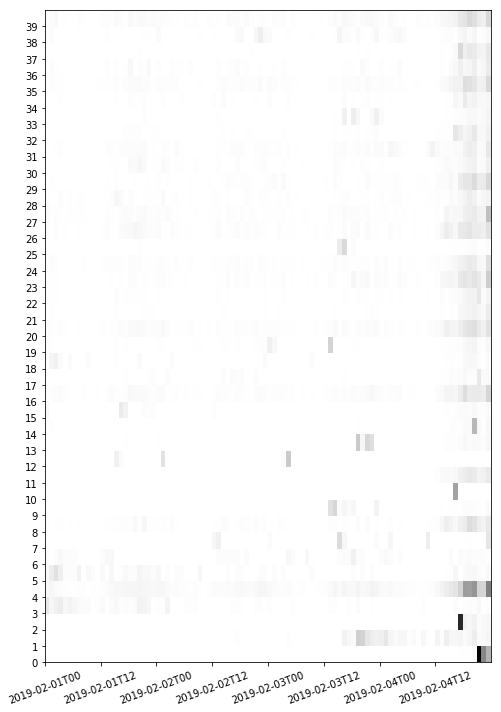

In [71]:
periods = np.arange('2019-02-01', '2019-02-05', dtype='datetime64[h]')
A = zeros((nr_components, periods.shape[0]))

for t, (mn_start, mn_end) in enumerate(zip(periods, periods + np.timedelta64(1, 'h'))):
    mask = (df.created_at > mn_start) & (df.created_at <= mn_end)
    W_minute = W[mask.values]
    
    for i in range(nr_components):
        A[i, t] = W_minute[:, i].sum()

plt.figure(figsize=(8,12))
plt.pcolormesh(A, cmap=cm.gray_r)
plt.ylim(0, A.shape[0])
plt.xlim(0, A.shape[1])
plt.yticks(np.arange(A.shape[0]))
plt.xticks(np.arange(0, A.shape[1], 12), periods[::12], rotation=20);

This plot shows that, even extracting a higher number of components, some of the components - the ones with highest activity - are the same as the ones extracted with less components. This means that we can increase the number of components to have a more rich list of components, but a small number of components (e.g. 20) is already sufficient to have an idea of the components that have the highest activity.

This behaviour is due to the fact that the activity of the different components are very heterogeneous. If we plot the activity of the different components in decreasing order, we'll se a broad curve, where most of the activity is related to a small number of components:

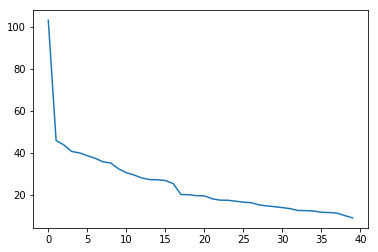

In [72]:
plot(np.sort(W.sum(axis=0))[::-1])

Again, for each component vector in $W$ (i.e., for each column of $W$), we can sort the weights of the component vector and select the row of $W$ with the highest weight for the component. If we go back to the list of status messages, we can select the corresponding status message for the row, which is the most representative status message for the component.

In [73]:
for c in range(nr_components):
    print('Topic', c)
    print(df.text.iloc[W[:, c].argsort()[-1]].replace('\n', ' '))
    print('*'*10)

Topic 0
President @realDonaldTrump: Please use the State of the Union to make lowering Rx costs a top priority. It's outrag… https://t.co/oXcUbggUuq
**********
Topic 1
Pledge to skip Trump, and watch the #SOTU response from @staceyabrams instead! #AbramsAddress https://t.co/8LQrdgtoRq
**********
Topic 2
Watch @TheRealHublife's broadcast: Ralph Northam Promoted to Grand Wizard, Superbowl Hangover and #SOTU Eve w/ Auth… https://t.co/J7QilSwc4d
**********
Topic 3
Sign the petition: Not one Democrat should attend Trump's #SOTU https://t.co/0hGKrph7s9 #ResistTrump via @CREDOMobile
**********
Topic 4
#SOTU https://t.co/vRBjwvT79v
**********
Topic 5
Tell Democrats: Don't give Trump an audience for his lies. Skip the #SOTU. https://t.co/gOG1ptzE9I #ResistTrump via @CREDOMobile
**********
Topic 6
#FollowTheWhiteRabbit #QAnon #GreatAwakening #SpyGate #WalkAway #QAnon #QArmy #MAGA  #SOTU    #SuperBowl… https://t.co/BRzqWdZaMY
**********
Topic 7
#SOTU @POTUS  @VP @HawleyMO @RepHartzler @RoyBlunt @

And finally we select the top weights in each row of the matrix $H$ to assess the top terms that define each component:

In [74]:
vocabulary_idx = dict((v,k) for k,v in vocabulary.items())
for c in range(nr_components):
    print (c, [vocabulary_idx[idx] for idx in H[c].argsort()[:-5:-1]])

0 ['lowering', 'rx costs', 'state union lowering', 'lowering rx costs']
1 ['watch response staceyabrams', 'staceyabrams instead', 'response staceyabrams instead', 'pledge skip']
2 ['promoted grand', 'northam promoted grand', 'grand wizard', 'northam promoted']
3 ['democrat attend', 'democrat attend trump', 'attend trump', 'attend trump https']
4 ['https', 'stateoftheunion', 'new', 'good']
5 ['tell democrats', 'audience lies', 'lies skip', 'audience lies skip']
6 ['qanon', 'followthewhiterabbit qanon greatawakening', 'greatawakening spygate walkaway', 'qanon greatawakening spygate']
7 ['rephartzler', 'vp hawleymo', 'hawleymo rephartzler', 'royblunt']
8 ['state', 'union', 'state union', 'union https']
9 ['powerful sermon', 'powerful sermon church', 'sermon', 'sermon church']
10 ['redbubble redbubbleartist https', 'wednesdaymotivation thursdaymotivation', 'redbubbleartist https', 'redbubbleartist']
11 ['tomorrow', 'night', 'tomorrow night', 'tomorrow https']
12 ['drainthedeepstate closing

# Agglomerative Matrix Factorization

In the previous examples, we extracted a single pair of matrices $W$ and $H$ for the matrix $X$. In the Agglomerative Matrix Factorization, we will extract a pair of matrices $W^{(t)}$ and $H^{(t)}$ for each interval $t$. We can also reduce the number of components extracted in each interval to 10, since the amount of messages to analyze in each interval is smaller than the full dataset, and we expect to have activity in a smaller number of components in each interval.

Since the amount of data in each interval is less and the number of components is also smaller, the time to process all intervals is less than the time to factorize the full matrix $X$. Also, another advantage of this method, is that the factorization of the intervals can be processed in parallel.

In [83]:
from sklearn import decomposition
nr_components = 10

W_list = []
H_list = []

tweets = []

periods = np.arange('2019-02-01', '2019-02-05', dtype='datetime64[h]')
idxs = arange(X.shape[0])

for mn_start, mn_end in zip(periods, periods + np.timedelta64(1, 'h')):
    mask = (df.created_at > mn_start) & (df.created_at <= mn_end)
    if mask.sum() == 0:
        #W_list.append(np.zeros((1, nr_components)))
        #H_list.append(np.zeros((10, X.shape[1])))
        continue
    tweets.append(df.text[mask].values)
    idxs_interval = idxs[mask.values]
    
    X_interval = X[idxs_interval, :]
    nmf = decomposition.NMF(n_components=nr_components, max_iter=20)
    W_interval = nmf.fit_transform(X_interval)
    H_interval = nmf.components_
    
    W_list.append(W_interval)
    H_list.append(H_interval)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 8466 but corresponding boolean dimension is 62816

Each interval produced a set of 10 different components. Now, we have to connect the components in interval $t$ with their similar components in interval $t+1$. Also, if in a given interval we extracted 10 components but some of them are very similar, we can aggregate the similar component in a single component.

All this complex aggregation can be easily achieved if we threat every component as an independent component and use agglomerative clustering (e.g., using **hierarchical clustering** available in `scipy`) to find out the hierarchy of similar clusters. Since we don't want two components that are too different from each other in the same cluster, we will use the method **complete** to compute the distance between two clusters. This method compares two different clusters by comparing the cosine distance between the farthest point of each cluster. 

In [76]:
from scipy.cluster.hierarchy import linkage, fcluster,inconsistent,leaves_list

F = numpy.concatenate(H_list)
Z = linkage(F, method='complete', metric='cosine')

Plotting the **dendrogram**, we can have an idea of the hierarchy of components.

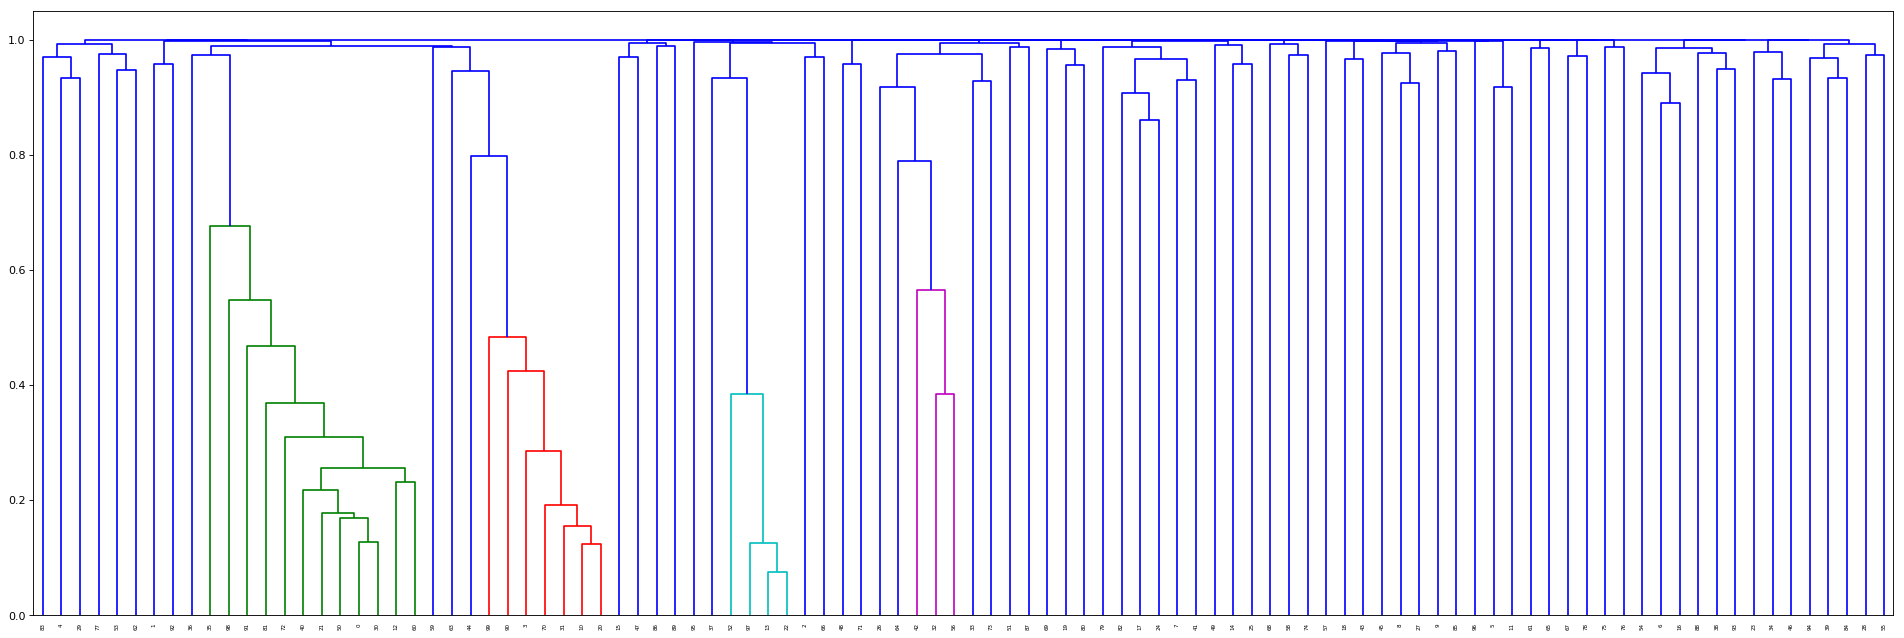

In [77]:
from scipy.cluster.hierarchy import dendrogram
figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
dend = dendrogram(Z)

In [ ]:
nr_intervals =  len(H_list)

Before calculating the stream matrix with the different clusters of components, we need to calculate the weight of each component separately. These weights are represented in a matrix $A$ as follows:

In [ ]:
# Calculate the weight matrix A for each component for each interval
A = np.zeros((nr_intervals, nr_components))
for i in range(nr_intervals):
    ns = np.sum(W_list[i], axis=1) + 0.0001
    for j in range(nr_components):
        normed = sum(W_list[i].T[j]/ns)
        A[i,j] = normed

Using this agglomerative method, we can extract hundreds of clusters that can refer to single events. We start with a high number of components (65 intervals, 10 components per interval) and we can tune the number of clusters by, for example, looking at the dendrogram and choosing a proper cut. Let's start by cutting the dendrogram at 0.8.

In [ ]:
clusterdata = fcluster(Z, 0.8, criterion='distance')
clusterdata.max()

From the weights of each component, we calculate the weight of each cluster as a matrix $M$. The weight of each cluster is the sum of the weights of the components it is composed.

In [ ]:
from scipy.cluster.hierarchy import leaves_list

# maxclust = 50
# clusterdata = fcluster(Z, maxclust, criterion='maxclust')

clusterdata = fcluster(Z, 0.8, criterion='distance')
clusterdata.max()

M = np.zeros((clusterdata.max(), nr_intervals))
leaveslist = leaves_list(Z)

def from_idx(k):
    i = int(k)%nr_components
    j = int(k/nr_components)
    return i,j

for i in leaveslist:
    
    cid = clusterdata[i]-1
    j,t = from_idx(i)
    M[cid,t] += A[t,j]

The matrix $M$ is the stream matrix that will be used in the visualization.

In [ ]:
plt.figure(figsize=(8,12))
plt.pcolormesh(M, cmap=cm.gray_r)
plt.ylim(0, M.shape[0])
plt.xlim(0, M.shape[1])
plt.yticks(np.arange(0, M.shape[0], 5))
plt.xticks(np.arange(0, M.shape[1], 12), periods[::12], rotation=20);